<a href="https://colab.research.google.com/github/alexxony/Pytorch/blob/master/U_net_DiceBCELoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Package Import
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets
import torch.nn.functional as F
import time

In [ ]:
# loading data
dir_data= '/content/drive/My Drive/UNet_pjt/datasets'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

In [ ]:
# train,val, test saving directory
# total frame is 30, train frame is 24, validation frame is 3, test frame is 3
nframe_train = 24
nframe_val = 3
nframe_test = 3
# set each save diretory
dir_save_train = os.path.join(dir_data,'train')
dir_save_val = os.path.join(dir_data,'val')
dir_save_test = os.path.join(dir_data,'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)
if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)
if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

In [ ]:
# generate random index of frame

id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

# saving train set
offset = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train,'label_%03d.npy'%i),label_)
    np.save(os.path.join(dir_save_train,'input_%03d.npy'%i),input_)

In [ ]:
# saving validation set

offset += nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val,'label_%03d.npy'%i),label_)
    np.save(os.path.join(dir_save_val,'input_%03d.npy'%i),input_)

In [ ]:
# saving test set

offset += nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test,'label_%03d.npy'%i),label_)
    np.save(os.path.join(dir_save_test,'input_%03d.npy'%i),input_)

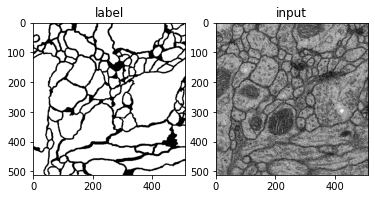

In [ ]:
#plot label and input
# left is segmentation (label) , right is cell image (input)
plt.subplot(121)
plt.imshow(label_,cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_,cmap='gray')
plt.title('input')

plt.show()

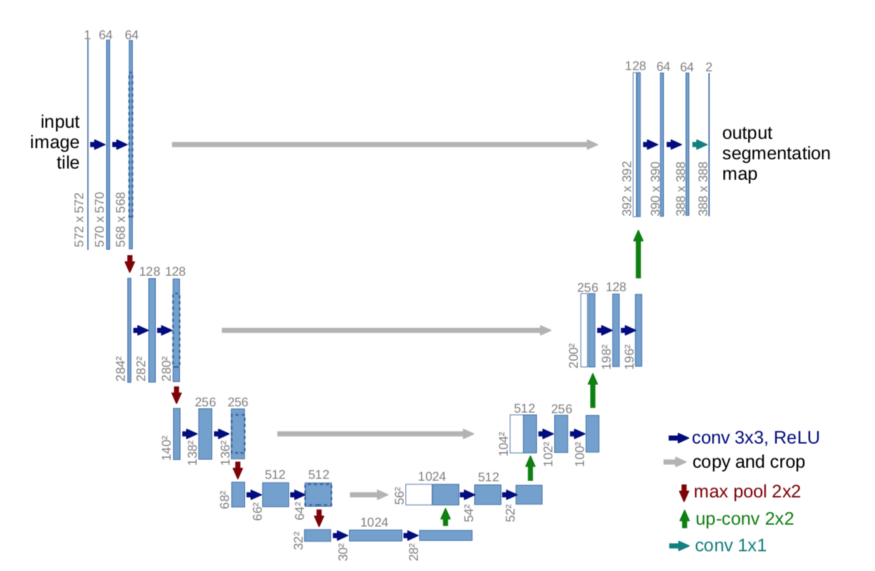![unet.jpg](attachment:unet.jpg)

In [ ]:
## Construct U-net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Blue Arrows : Convoultion + Batch normalization, ReLu
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path :encoding path
        # First Stage 
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        # Red Arrow : Max pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # Second Stage 
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        # Red Arrow : Max pooling
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # Third Stage 
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
        # Fourth Stage 
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        # Fifth Stage 

        # Expansive path : decoding path
        # Fifth Stage 
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        
        # Fourth Stage : pair to encoding path
        # Green arrow = upconvolution layer
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        # in_channels is not 512 since gray arrow is concatnated
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        # Third Stage 
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        # Second Stage 
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        # First Stage 
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        # Turquoise Arrow
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Connecting Encoder and Decoder 
    def forward(self, x):
        # First block
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        # Second block
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        # Third block
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        # Fourth block
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        # Fifth block

        enc5_1 = self.enc5_1(pool4)
        
        # Fifth block

        dec5_1 = self.dec5_1(enc5_1)
        
        # Fourth block
        unpool4 = self.unpool4(dec5_1)    
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)    
        # Third block
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        # Second block
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        # First block
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [ ]:
# Making Dataloader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dir_data, transform=None):
        self.dir_data = dir_data
        self.transform = transform
        # take list of dir_data
        lst_data = os.listdir(self.dir_data)

        lst_label = [f for f in lst_data if f.startswith('label')] # Checking string : 'label' existing = True 
        lst_input = [f for f in lst_data if f.startswith('input')] # Checking string : 'input' existing =True

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)
    # return file corresponding to index
    def __getitem__(self, index):
        label = np.load(os.path.join(self.dir_data, self.lst_label[index]))
        inputs = np.load(os.path.join(self.dir_data, self.lst_input[index]))

        # normalize
        label = label/255.0
        inputs = inputs/255.0
        label = label.astype(np.float32)
        inputs = inputs.astype(np.float32)
        
        # IF input data dimension is 2 , add a channel (batch, channel, row, column in pytorch) 
        if label.ndim == 2:  
            label = label[:,:,np.newaxis]
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 

        data = {'input':inputs, 'label':label}

        if self.transform:
            data = self.transform(data) #  calling class for transform -> __call__ run 
        return data

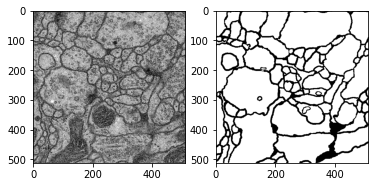

In [ ]:
# generating Dataset object and plot

db = Dataset(dir_data='/content/drive/My Drive/UNet_pjt/datasets/train')

data = db.__getitem__(0)

inputs = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(inputs.squeeze(),cmap='gray') # use squeeze() for removing dimenstion which value is 1 
plt.subplot(122)
plt.imshow(label.squeeze(),cmap='gray')

In [ ]:
## Transform class 

# Numpy to Tensor
# numpy : (row,column , channel) -> tensor : (channel, row, column)
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data
# Normalization
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data
    
# For data augumentation
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        #left right flip
        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
        #up down flip
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

In [ ]:
transform = transforms.Compose([Normalization(0.5,0.5),RandomFlip(),ToTensor()]) # compose three class above -> transform instance

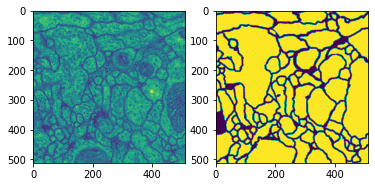

In [ ]:
db_train = Dataset(dir_data=os.path.join(dir_data,'train'),transform= transform)

data = db_train.__getitem__(5)

inputs = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(inputs.squeeze()) # Yellow spot is 1, Dark green spot is 0 : normalized
plt.subplot(122)
plt.imshow(label.squeeze())

In [ ]:
inputs # nomalize

tensor([[[-0.0510, -0.1529, -0.1059,  ..., -0.2784, -0.1373,  0.0196],
         [ 0.0118, -0.0902, -0.0745,  ..., -0.2392, -0.2863, -0.0510],
         [ 0.0353,  0.0745,  0.0745,  ..., -0.3882, -0.4275, -0.2000],
         ...,
         [-0.3882, -0.4980, -0.5137,  ..., -0.1608, -0.3412, -0.4353],
         [-0.3882, -0.4667, -0.3882,  ..., -0.0745, -0.2392, -0.3255],
         [-0.3961, -0.2784, -0.0902,  ..., -0.1608, -0.2863, -0.2314]]])

In [ ]:
label # un nomarlize

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
## Hyper parameter setting 

lr = 1e-3
batch_size = 4
num_epoch = 100

ckpt_dir = '/content/drive/My Drive/UNet_pjt/checkpoint9'
log_dir = '/content/drive/My Drive/UNet_pjt/log9'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
# loading datasets with applying transform
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(dir_data=os.path.join(dir_data,'train'),transform=transform)

# Loadred dataset -> appllying Dataloader with batch 
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)

# Same as validation set
dataset_val = Dataset(dir_data=os.path.join(dir_data,'val'),transform = transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size , shuffle=True)

# Loading network
net = UNet().to(device) # device : cpu or gpu

# loss function is Binary Cross entropy with logistic
fn_loss = DiceBCELoss().to(device)

# Optimizer is Adam
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# other variables 
num_train = len(dataset_train)
num_val = len(dataset_val)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : rounding
num_val_for_epoch = np.ceil(num_val/batch_size)

# Other function settinguu
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # detach Tensor on device and transform to numpy
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # classifer: Indicator function that threshold 
# Tensorbord
writer_train = SummaryWriter(log_dir=os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))

In [ ]:
# Network Saving 
# Saving trained completed network 
# net : network parameter, optim goes to dic
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

In [ ]:
  ## saving network
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch


In [ ]:
# network traning 
start_epoch = 0
start = time.time()

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1 isindex start point
        # forward
        label = data['label'].to(device)   
        inputs = data['input'].to(device)
        output = net(inputs) 

        # backward
        optim.zero_grad()  # gradient defaulting
        loss = fn_loss(output, label)  # loss between output and label
        loss.backward() # gradient backpropagation
        optim.step() #  update of Each layer with backpropagate gradient parameters

        # save loss
        loss_arr += [loss.item()]

        # saving output to tensorbord
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    
    # validation
    with torch.no_grad(): # no backpropagation, only loss from ground truth cuz validation 
        net.eval() # set network as evaluation
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss 
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04d | Loss %.4f'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard save
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # save network per every epoch
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()
print("time :", time.time() - start)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid : epoch 0001 / 0100 | Batch 0001 \ 0001 | Loss 0.9400
valid : epoch 0002 / 0100 | Batch 0001 \ 0001 | Loss 0.7791
valid : epoch 0003 / 0100 | Batch 0001 \ 0001 | Loss 0.7533
valid : epoch 0004 / 0100 | Batch 0001 \ 0001 | Loss 0.4960
valid : epoch 0005 / 0100 | Batch 0001 \ 0001 | Loss 0.4452
valid : epoch 0006 / 0100 | Batch 0001 \ 0001 | Loss 0.4831
valid : epoch 0007 / 0100 | Batch 0001 \ 0001 | Loss 0.3705
valid : epoch 0008 / 0100 | Batch 0001 \ 0001 | Loss 0.3678
valid : epoch 0009 / 0100 | Batch 0001 \ 0001 | Loss 0.3584
valid : epoch 0010 / 0100 | Batch 0001 \ 0001 | Loss 0.3694
valid : epoch 0011 / 0100 | Batch 0001 \ 0001 | Loss 0.3363
valid : epoch 0012 / 0100 | Batch 0001 \ 0001 | Loss 0.3346
valid : epoch 0013 / 0100 | Batch 0001 \ 0001 | Loss 0.3325
valid : epoch 0014 / 0100 | Batch 0001 \ 0001 | Loss 0.3489
valid : epoch 0015 / 0100 | Batch 0001 \ 0001 | Loss 0.3309
valid : epoch 0016 / 0100 | Batch 0001 \ 0001 | Loss 0.3300
valid : epoch 0017 / 0100 | Batch 0001 \

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='/content/drive/My Drive/UNet_pjt/log9'

In [ ]:
result_dir = '/content/drive/My Drive/UNet_pjt/log9/result'

if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir,'png'))
    os.makedirs(os.path.join(result_dir,'numpy'))

In [ ]:
# loading test datasets with applying transform
# no RandomFlip: no need augumentation
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(dir_data=os.path.join(dir_data,'test'),transform=transform)

# Loadred dataset -> appllying Dataloader with batch 
# no shuffle cuz test
loader_test = DataLoader(dataset_test, batch_size = batch_size)

# loading network
net = UNet().to(device) # device : cpu or gpu

# loss, optimizer define
fn_loss = DiceBCELoss().to(device)
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# various variables setting
num_test = len(dataset_test)
num_test_for_epoch = np.ceil(num_test/batch_size) # np.ceil : rounding


In [ ]:
# Network Saving 
# Saving trained completed network 
# net : network parameter, optim goes to dic
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

## load network
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # if no saved network, return input
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # take all fiels in ckpt_dir
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f)))) #  sort in epoch -> lastest indexing

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1])) # load lastest one among saved model check point

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch


In [ ]:
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # loading saved network

In [ ]:
# test
with torch.no_grad(): #  no backpropagation, only loss from ground truth cuz test 
    net.eval() # network is for  evaluation 
    loss_arr = []

    for batch, data in enumerate(loader_test,1):
        # forward
        label = data['label'].to(device)
        inputs = data['input'].to(device)
        output = net(inputs)

        # loss 
        loss = fn_loss(output,label)
        loss_arr += [loss.item()]
        print('Test : Batch %04d \ %04d | Loss %.4f'%(batch,num_test_for_epoch,np.mean(loss_arr)))

        # save output as numpy and png 
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_classifier(output))

        for j in range(label.shape[0]):
            id = num_test_for_epoch * (batch-1) + j

            plt.imsave(os.path.join(result_dir,'png','label_%04d.png'%id), label[j].squeeze(), cmap = 'gray')
            plt.imsave(os.path.join(result_dir,'png','inputs_%04d.png'%id), inputs[j].squeeze(), cmap = 'gray')
            plt.imsave(os.path.join(result_dir,'png','output_%04d.png'%id), output[j].squeeze(), cmap = 'gray')

            np.save(os.path.join(result_dir,'numpy','label_%04d.np'%id),label[j].squeeze())
            np.save(os.path.join(result_dir,'numpy','inputs_%04d.np'%id),inputs[j].squeeze())
            np.save(os.path.join(result_dir,'numpy','output_%04d.np'%id),output[j].squeeze())


print('Average Test : Batch %04d \ %04d | Loss %.4f'%(batch,num_test_for_epoch,np.mean(loss_arr)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test : Batch 0001 \ 0001 | Loss 0.2476
Average Test : Batch 0001 \ 0001 | Loss 0.2476


Text(0.5, 1.0, 'label')

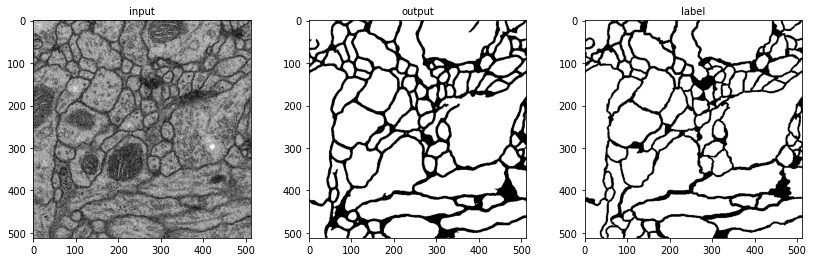

In [ ]:
result_numpy_dir = '/content/drive/My Drive/UNet_pjt/log9/result/numpy'


lst_data = os.listdir(result_numpy_dir)

lst_label = [f for f in lst_data if f.startswith('label')] # string.startswith('argu') 
lst_input = [f for f in lst_data if f.startswith('inputs')] 
lst_output = [f for f in lst_data if f.startswith('out')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

id = 2

label = np.load(os.path.join(result_numpy_dir, lst_label[id]))
inputs = np.load(os.path.join(result_numpy_dir, lst_input[id]))
output = np.load(os.path.join(result_numpy_dir, lst_output[id]))

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.titlesize'] = 10

plt.subplot(131)
plt.imshow(inputs, cmap='gray')
plt.title('input',)

plt.subplot(132)
plt.imshow(output, cmap='gray')
plt.title('output',)

plt.subplot(133)
plt.imshow(label, cmap= 'gray')
plt.title('label')